In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import xarray as xr
from dask.distributed import Client
from deap import algorithms, base, creator, tools
from plotly import graph_objects as go
from seapopym.configuration.no_transport.configuration import NoTransportConfiguration
from seapopym.configuration.no_transport.parameter import (
    ForcingParameters,
    FunctionalGroups,
    KernelParameters,
    NoTransportParameters,
)
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.configuration.parameters.parameter_functional_group import (
    FunctionalGroupUnit,
    FunctionalGroupUnitMigratoryParameters,
    FunctionalGroupUnitRelationParameters,
)
from seapopym.model.no_transport_model import NoTransportModel
from seapopym.standard.units import StandardUnitsLabels

random.seed(64)

In [2]:
xr.set_options(
    keep_attrs=True,
    display_expand_attrs=False,
    display_expand_data=False,
    display_expand_coords=False,
    display_expand_data_vars=False,
)

WET_TO_CARBON = 1 / 11.9

## Forcing


Forcing data from seapodym model


In [3]:
time_start, time_end = "1998-01-01", "2022-01-01"

In [4]:
hot_data = xr.open_dataset("../1_data_processing/1_1_Forcing/bats_cmems.zarr", engine="zarr")
hot_data["T"].attrs["units"] = StandardUnitsLabels.temperature.units
hot_data = hot_data.sel(time=slice(time_start, time_end))
hot_data.load()

<xarray.Dataset> Size: 807kB
Dimensions:              (time: 8767, depth: 3, latitude: 1, longitude: 1)
Coordinates: (4)
Data variables: (13)
Attributes: (10)

In [5]:
cafe_npp = xr.open_dataset("../1_data_processing/1_1_Forcing/bats_cafe.zarr", engine="zarr")
cafe_npp = cafe_npp.sel(time=slice(time_start, time_end))
cafe_npp = cafe_npp.dropna("time")
cafe_npp = cafe_npp.resample(time="D").interpolate("linear")
cafe_npp.lat.attrs = {"units": "degrees_north", "long_name": "latitude", "axis": "Y"}
cafe_npp.lon.attrs = {"units": "degrees_east", "long_name": "longitude", "axis": "X"}
cafe_npp = cafe_npp.rename({"lat": "latitude", "lon": "longitude"})
cafe_npp.load()

<xarray.Dataset> Size: 140kB
Dimensions:    (time: 8767, latitude: 1, longitude: 1)
Coordinates: (3)
Data variables: (1)
Attributes: (5)

Observation data from Hot station


In [6]:
hot_obs = xr.open_dataset("../1_data_processing/1_1_Forcing/bats_obs.zarr", engine="zarr")
hot_obs = hot_obs.sel(time=slice(time_start, time_end))
hot_obs.load()

<xarray.Dataset> Size: 12MB
Dimensions:                        (time: 3309, depth: 8, latitude: 1,
                                    longitude: 1, sieve_size: 5)
Coordinates: (5)
Data variables: (39)

Generate the observed zooplankton data to be used further in the cost function


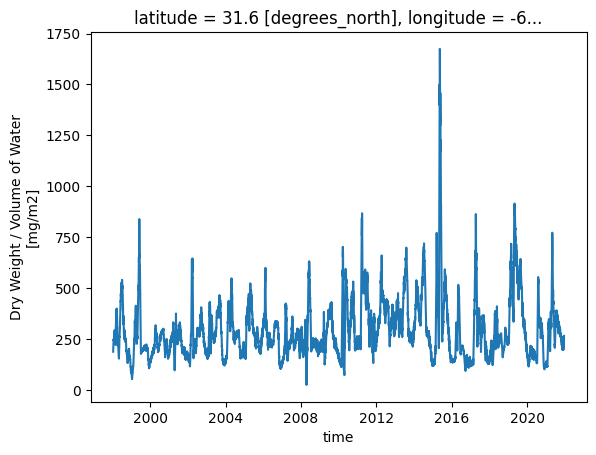

In [7]:
def process_obs(obs: xr.DataArray):
    obs = obs.mean("depth").cf.isel(X=0, Y=0)
    obs = obs.where(obs > 0)
    obs = obs.sum("sieve_size")
    obs = obs.where(obs.notnull(), drop=True)
    obs = obs.pint.quantify().pint.to("mg/m3").pint.dequantify()
    return obs


zoo_obs_migrant = process_obs(hot_obs["dry_weight_migrant"])
zoo_obs_resident = process_obs(hot_obs["dry_weight_resident"])
zoo_obs = zoo_obs_migrant + zoo_obs_resident
zoo_obs = zoo_obs.where(zoo_obs > 0, drop=True).rename("observation")
zoo_obs = zoo_obs.resample(time="D").interpolate("linear")
zoo_obs = zoo_obs * hot_data.pelagic_layer_depth.isel(depth=0)
zoo_obs.attrs["units"] = "mg/m2"
zoo_obs.plot()

## Function to automatically generate model


In [8]:
def gen_fgroup(
    tr_max: float = 10.38,
    tr_rate: float = -0.11,
    inv_lambda_max: float = 150,
    inv_lambda_rate: float = 0.15,
    day_layer: float = 1,
    night_layer: float = 1,
    energy_transfert: float = 0.1668,
) -> FunctionalGroups:
    """Generate a FunctionalGroups object with the given parameters."""
    return FunctionalGroups(
        functional_groups=[
            FunctionalGroupUnit(
                name=f"D{day_layer}N{night_layer}",
                migratory_type=FunctionalGroupUnitMigratoryParameters(day_layer=day_layer, night_layer=night_layer),
                functional_type=FunctionalGroupUnitRelationParameters(
                    inv_lambda_max=inv_lambda_max,
                    inv_lambda_rate=inv_lambda_rate,
                    temperature_recruitment_rate=tr_rate,
                    cohorts_timesteps=[1] * np.ceil(tr_max).astype(int),
                    temperature_recruitment_max=tr_max,
                ),
                energy_transfert=energy_transfert,
            )
        ]
    )


def gen_model(forcing_parameters, functional_groups_parameters, **kwargs) -> NoTransportModel:
    """
    Generate a NoTransportModel with the given parameters.

    kwargs:
        - environment_parameters: EnvironmentParameter = EnvironmentParameter,
        - kernel_parameters: KernelParameters = KernelParameters
    """
    return NoTransportModel(
        configuration=NoTransportConfiguration(
            parameters=NoTransportParameters(
                forcing_parameters=forcing_parameters,
                functional_groups_parameters=functional_groups_parameters,
                **kwargs,
            )
        )
    )

## Setup


The forcing data


In [9]:
hot_data_parameter = ForcingParameters(
    temperature=ForcingUnit(forcing=hot_data["T"], resolution=0.08333),
    primary_production=ForcingUnit(forcing=cafe_npp["CAFE"], resolution=0.08333),
)

2024-08-28 14:35:27,160 :: Seapodym ::  WARNING ::
|	CAFE unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



The initial conditions


In [10]:
fgroups = gen_fgroup()
setup_model = gen_model(
    hot_data_parameter,
    fgroups,
    kernel_parameters=KernelParameters(compute_initial_conditions=True, compute_preproduction=True),
)
setup_model.run()
initial_conditions = setup_model.export_initial_conditions()

2024-08-28 14:35:27,185 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-08-28 14:35:27,192 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.



2024-08-28 14:35:27,201 :: Seapodym ::  DEBUG ::
|	Direct computation for _wrapper_mesh_day_lengths.

2024-08-28 14:35:27,291 :: Seapodym ::  DEBUG ::
|	Direct computation for _average_temperature.

2024-08-28 14:35:27,311 :: Seapodym ::  DEBUG ::
|	Direct computation for _apply_coefficient_to_primary_production_helper.

2024-08-28 14:35:27,322 :: Seapodym ::  DEBUG ::
|	Direct computation for _min_temperature_by_cohort_helper.

2024-08-28 14:35:27,324 :: Seapodym ::  DEBUG ::
|	Direct computation for _mask_temperature_helper.

2024-08-28 14:35:27,331 :: Seapodym ::  DEBUG ::
|	Direct computation for _cell_area_helper.

2024-08-28 14:35:27,355 :: Seapodym ::  DEBUG ::
|	Direct computation for _mortality_field_helper.

2024-08-28 14:35:27,361 :: Seapodym ::  DEBUG ::
|	Direct computation for _production_helper.

2024-08-28 14:35:31,364 :: Seapodym ::  DEBUG ::
|	Direct computation for _biomass_helper.



Update the forcing data with initial conditions


In [11]:
hot_data_parameter = ForcingParameters(
    temperature=ForcingUnit(forcing=hot_data["T"], resolution=0.08333),
    primary_production=ForcingUnit(forcing=cafe_npp["CAFE"], resolution=0.08333),
    initial_condition_biomass=ForcingUnit(forcing=initial_conditions["initial_condition_biomass"], resolution=0.08333),
    initial_condition_production=ForcingUnit(
        forcing=initial_conditions["initial_condition_production"], resolution=0.08333
    ),
)

2024-08-28 14:35:31,791 :: Seapodym ::  WARNING ::
|	CAFE unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Cost function


In [12]:
from typing import Literal


def cost_function(args: tuple[float, float, float, float, float], method: Literal["MAE", "MSE"] = "MSE"):
    """Use the Mean Absolute Error (MAE) method or the Mean Squared Error (MSE) method to calculate the cost."""
    (
        energy_transfert,
        tr_max,
        tr_rate,
        inv_lambda_max,
        inv_lambda_rate,
    ) = args
    fgroups = gen_fgroup(
        energy_transfert=energy_transfert,
        tr_max=tr_max,
        tr_rate=tr_rate,
        inv_lambda_max=inv_lambda_max,
        inv_lambda_rate=inv_lambda_rate,
    )

    setup_model = gen_model(hot_data_parameter, fgroups)
    setup_model.run()

    biomass_pred = setup_model.export_biomass().pint.quantify().pint.to("mg / meter ** 2").pint.dequantify()
    biomass_pred = biomass_pred[0, :, 0, 0].rename("prediction")
    if method == "MSE":
        cost = float(((zoo_obs - biomass_pred) ** 2).mean())
    else:
        cost = float(np.abs((zoo_obs - biomass_pred)).mean())

    return (cost,)

## DEAP - Genetic algorithm


Create the population of the genetic algorithm.


In [13]:
def random_exclusive(a, b):
    if a >= b:
        raise ValueError("La borne inférieure doit être inférieure à la borne supérieure.")

    while True:
        value = random.uniform(a, b)
        if value != a and value != b:
            return value


parameters_boundaries = {
    "energy_transfert": (0, 0.5),
    "tr_max": (0, 50),
    "tr_rate": (-1, 0),
    "inv_lambda_max": (1, 1000),
    "inv_lambda_rate": (0, 1),
}
lower_boundary = [values[0] for values in parameters_boundaries.values()]
upper_boundary = [values[1] for values in parameters_boundaries.values()]

# Crowding degree of the mutation. A high eta will produce a mutant resembling its parent, while a small eta will
# produce a solution much more different (resulting in 1 / 1+ETA) :
ETA = 1
# Independent probability for each attribute to be mutated :
INDPB = 0.1  # 0.05
# The probability of mating two individuals :
CXPB = 0.5
# The probability of mutating an individual
MUTPB = 0.2  # 0.1


NGEN = 10
number_of_individuals = 200

In [14]:
toolbox = base.Toolbox()

creator.create("Fitness", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.Fitness)

for parameter, boundaries in parameters_boundaries.items():
    lb, ub = boundaries
    toolbox.register(parameter, random_exclusive, lb, ub)

toolbox.register(
    "individual",
    tools.initCycle,
    creator.Individual,
    (
        toolbox.energy_transfert,
        toolbox.tr_max,
        toolbox.tr_rate,
        toolbox.inv_lambda_max,
        toolbox.inv_lambda_rate,
    ),
    n=1,
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", cost_function)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutPolynomialBounded, eta=ETA, indpb=INDPB, low=lower_boundary, up=upper_boundary)
toolbox.register("select", tools.selTournament, tournsize=3)

The main function to run the genetic algorithm.


In [ ]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54567,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:54581,Total threads: 2
Dashboard: http://127.0.0.1:54585/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:54570,


2024-08-28 23:19:18,029 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 3 memory: 65 MB fds: 182>>
Traceback (most recent call last):
  File "/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/tornado/ioloop.py", line 937, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/distributed/system_monitor.py", line 168, in update
    net_ioc = psutil.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/psutil/__init__.py", line 2139, in net_io_counters
    rawdict = _psplatform.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 12] Cannot allocate memory
2024-08-29 08:02:04,616 - distributed.scheduler - WARNING - Worker failed to heartbeat for 2078s

In [16]:
def main_manual(population, toolbox, cxpb, mutpb, ngen, verbose=__debug__):
    halloffame = tools.HallOfFame(300)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    logbook = tools.Logbook()
    logbook.header = ["gen", "nevals"] + (stats.fields if stats else [])

    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    invalid_ind_as_list = [list(ind) for ind in invalid_ind]  # For compatibility with DASK
    futures_results = client.map(toolbox.evaluate, invalid_ind_as_list)
    fitnesses = client.gather(futures_results)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)

    for gen in range(1, ngen + 1):
        offspring = toolbox.select(population, len(population))

        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)  # MUTATE + MATE

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        invalid_ind_as_list = [list(ind) for ind in invalid_ind]  # For compatibility with DASK
        futures_results = client.map(toolbox.evaluate, invalid_ind_as_list)
        fitnesses = client.gather(futures_results)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        if halloffame is not None:
            halloffame.update(offspring)

        population[:] = offspring

        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)

    return population, logbook, halloffame


pop, logbook, hof = main_manual(
    population=toolbox.population(n=number_of_individuals),
    toolbox=toolbox,
    cxpb=CXPB,
    mutpb=MUTPB,
    ngen=NGEN,
)

2024-08-28 14:35:34,306 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-08-28 14:35:34,306 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-08-28 14:35:34,306 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-08-28 14:35:34,306 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-08-28 14:35:34,309 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-08-28 14:35:34,309 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-08-28 14:35:34,309 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-08-28 14:35:34,310 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-08-28 14:35:34,318 :: Seapodym ::  DEBUG ::
|	Direct computation for _wrapper_mesh_day_lengths.

2024-08-28 14:35:34,319 :: Seapodym ::  DEBUG ::
|	Direct computation for _wrapper_mesh_day_lengths.

2024-08-28 14:35:34,320 :: Seapodym ::  DEBU

In [17]:
pd.DataFrame(logbook).set_index("gen")

,nevals,avg,std,min,max
gen,,,,,
0,200,5.039992e+07,2.359774e+08,24734.182264,1.642175e+09
1,113,2.940282e+07,3.670133e+08,24734.182264,5.175506e+09
2,112,1.618321e+06,1.467754e+07,24734.182264,1.821116e+08
3,116,4.997718e+07,6.202641e+08,24688.007783,8.756515e+09
4,125,1.747832e+07,1.034592e+08,24664.086202,1.177702e+09
5,121,5.663968e+06,5.502636e+07,24664.086202,7.441137e+08
6,134,6.801611e+05,6.320291e+06,24664.086202,7.696018e+07
7,112,2.075309e+05,1.500655e+06,24664.086202,1.527437e+07
8,104,8.483588e+06,9.513866e+07,24664.086202,1.297727e+09


In [18]:
hof_df = pd.DataFrame(hof, columns=parameters_boundaries.keys())
hof_df["fitness"] = [ind.fitness.values[0] for ind in hof]
hof_df = hof_df.sort_values("fitness")

In [19]:
# create a plotly box plot for hof_df, each columns is a subplot
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=5, subplot_titles=list(parameters_boundaries.keys()))
for i, (parameter, boundaries) in enumerate(parameters_boundaries.items()):
    fig.add_trace(px.box(hof_df, y=parameter).data[0], row=1, col=i + 1)
fig.show()

In [20]:
color = (hof_df["fitness"] - hof_df["fitness"].max()).abs()
color = color / color.max()
fig = px.parallel_coordinates(
    hof_df,
    color=color,
    dimensions=list(parameters_boundaries.keys()),
    labels=parameters_boundaries.keys(),
    color_continuous_scale=[[0, "rgb(255,0,0,0.5)"], [0.6, "rgb(200,0,0,0.5)"], [1, "green"]],
    title="BATS parameters optimization",
)
# set color bar title to "Fitness"
fig.update_layout(coloraxis_colorbar=dict(title="Fitness"))
fig.show()

Parameters initial values:

-   energy_transfert: float = 0.1668
-   tr_max: float = 10.38
-   tr_rate: float = -0.11
-   inv_lambda_max: float = 150
-   inv_lambda_rate: float = 0.15


In [21]:
print("Best individual is: ")
for name, value in zip(parameters_boundaries.keys(), hof[2]):
    print(f"{name} : {value}")

Best individual is: 
energy_transfert : 0.4840205094293988
tr_max : 4.1832955192534325
tr_rate : -0.6312802924623547
inv_lambda_max : 6.33792202710464
inv_lambda_rate : 0.06382836531522529


In [22]:
# run the model for this parameters
best_run = gen_model(
    hot_data_parameter,
    gen_fgroup(
        energy_transfert=hof[0][0],
        tr_max=hof[0][1],
        tr_rate=hof[0][2],
        inv_lambda_max=hof[0][3],
        inv_lambda_rate=hof[0][4],
    ),
)
best_run.run()

2024-08-28 14:37:00,808 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-08-28 14:37:00,844 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-08-28 14:37:00,855 :: Seapodym ::  DEBUG ::
|	Direct computation for _wrapper_mesh_day_lengths.

2024-08-28 14:37:00,906 :: Seapodym ::  DEBUG ::
|	Direct computation for _average_temperature.

2024-08-28 14:37:00,922 :: Seapodym ::  DEBUG ::
|	Direct computation for _apply_coefficient_to_primary_production_helper.

2024-08-28 14:37:00,928 :: Seapodym ::  DEBUG ::
|	Direct computation for _min_temperature_by_cohort_helper.

2024-08-28 14:37:00,930 :: Seapodym ::  DEBUG ::
|	Direct computation for _mask_temperature_helper.

2024-08-28 14:37:00,937 :: Seapodym ::  DEBUG ::
|	Direct computation for _cell_area_helper.

2024-08-28 14:37:00,967 :: Seapodym ::  DEBUG ::
|	Direct computation for _mortality_field_helper.

2024-08-28 14:37:00,973 :: Seapodym ::  DEBUG ::
|	Direct computation for _productio

In [30]:
pred = best_run.export_biomass()[0, :, 0, 0].pint.quantify().pint.to("mg * m-2").to_dataframe()["biomass"]
obs = zoo_obs.rename("observation")[:, 0, 0].to_dataframe()["observation"]
lmtl = hot_data["zooc"].pint.quantify().pint.to("mg * m-2")[:, 0, 0].to_dataframe()["zooc"]

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/core/variable.py:338: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/core/variable.py:338: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



In [32]:
fig = go.Figure(
    [
        go.Scatter(x=pred.index, y=pred, name="Prediction"),
        go.Scatter(x=obs.index, y=obs, name="Observations"),
        go.Scatter(x=lmtl.index, y=lmtl, name="LMTL"),
    ]
)
# change title and x,y labels
fig.update_layout(
    title="Comparison of the observations and Seapopym in BATS using CAFE pp",
    xaxis_title="Time",
    yaxis_title="Biomass (mg/m^2)",
)

In [37]:
pred_monthly = pred.resample("ME").mean()
obs_monthly = obs.resample("ME").mean()
lmtl_monthly = lmtl.resample("ME").mean()

fig = go.Figure(
    [
        go.Scatter(x=pred_monthly.index, y=pred_monthly, name="Prediction"),
        go.Scatter(x=obs_monthly.index, y=obs_monthly, name="Observations"),
        go.Scatter(x=lmtl_monthly.index, y=lmtl_monthly, name="LMTL"),
    ]
)
# change title and x,y labels
fig.update_layout(
    title="Comparison of the observations and Seapopym in BATS using CAFE pp",
    xaxis_title="Time",
    yaxis_title="Biomass (mg/m^2)",
)

2024-08-29 08:02:04,754 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/distributed/worker.py", line 1250, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/distributed/utils_comm.py", line 459, in retry_operation
    return await retry(
           ^